<a href="https://colab.research.google.com/github/chandagrover/Machine-Learning/blob/master/2SMILEVAEGeneration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Basic Installs and Imports**

In [1]:
!wget -c https://repo.continuum.io/miniconda/Miniconda3-py37_4.8.3-Linux-x86_64.sh
!chmod +x Miniconda3-py37_4.8.3-Linux-x86_64.sh
!time bash ./Miniconda3-py37_4.8.3-Linux-x86_64.sh -b -f -p /usr/local
!time conda install -q -y -c conda-forge rdkit
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')

--2020-09-20 07:23:59--  https://repo.continuum.io/miniconda/Miniconda3-py37_4.8.3-Linux-x86_64.sh
Resolving repo.continuum.io (repo.continuum.io)... 104.18.201.79, 104.18.200.79, 2606:4700::6812:c84f, ...
Connecting to repo.continuum.io (repo.continuum.io)|104.18.201.79|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.3-Linux-x86_64.sh [following]
--2020-09-20 07:23:59--  https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.3-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.131.3, 104.16.130.3, 2606:4700::6810:8203, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.131.3|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

PREFIX=/usr/local
Unpacking payload ...
Solving environment: / - \ | / - \ | / - \ | failed with initial 

In [2]:
# General Imports
import os
import pandas as pd
import numpy as np
import sklearn
from rdkit import Chem
from rdkit.Chem import Draw, Descriptors
from matplotlib import pyplot as plt
import re

# **SMILES Data Fetching From Zinc Database**

In [3]:
WEIGHTS_FOLDER = 'sample_data/weights/'
smifile = "sample_data/AAAA.smi"
data = pd.read_csv(smifile, delimiter = " ", names = ["smiles","zinc_id"])
NUM_SMILES = len(data)
data["smiles"].head()


0                                     smiles
1                 Cn1cnc2c1c(=O)n(C)c(=O)n2C
2    O=C(O)[C@@H]1/C(=C/CO)O[C@@H]2CC(=O)N21
3                   Cn1c2nncnc2c(=O)n(C)c1=O
4                 Cn1cnc2c1c(=O)[nH]c(=O)n2C
Name: smiles, dtype: object

In [4]:
from sklearn.model_selection import train_test_split
smiles_train, smiles_test = train_test_split(data["smiles"])
print(smiles_train.shape)
print(smiles_test.shape)
print(NUM_SMILES)

(2844,)
(948,)
3792


In [5]:
charset = set("".join(list(data.smiles))+"!E")
char_to_int = dict((c,i) for i,c in enumerate(charset))
int_to_char = dict((i,c) for i,c in enumerate(charset))
# embed = max([len(smile) for smile in data.smiles]) + 5
embed = max([len(smile) for smile in data.smiles])+2
print(char_to_int)
print(len(charset), embed)
print(embed)

{'o': 0, 'l': 1, '+': 2, '-': 3, '\\': 4, 'P': 5, '2': 6, 'c': 7, 'm': 8, '/': 9, '4': 10, ')': 11, ']': 12, '6': 13, '5': 14, '@': 15, '1': 16, 'S': 17, 'e': 18, 'N': 19, '=': 20, '3': 21, 's': 22, '(': 23, 'B': 24, '!': 25, '[': 26, 'i': 27, 'E': 28, '#': 29, 'H': 30, 'C': 31, 'n': 32, 'O': 33, 'F': 34}
35 58
58


In [6]:
print(type(smiles_train))
print(smiles_train.values[0])
print(len(smiles_train.values[0]))
print(type(smiles_train.values[0]))

<class 'pandas.core.series.Series'>
Cn1c2ncc(=O)[nH]c2c(=O)[nH]c1=O
31
<class 'str'>


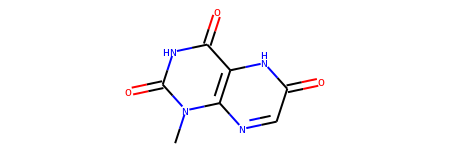

In [7]:
from rdkit.Chem.Draw import IPythonConsole
m = Chem.MolFromSmiles(smiles_train.values[0])
m

In [8]:
def vectorize(smiles):
        onehot_flatList=[[]]
        one_hot =  np.zeros((smiles.shape[0], embed , len(charset)),dtype=np.int8)
        print(one_hot.shape)
        for i,smile in enumerate(smiles):
            #encode the startchar
            one_hot[i,0,char_to_int["!"]] = 1
            #encode the rest of the chars
            for j,c in enumerate(smile):
                one_hot[i,j+1,char_to_int[c]] = 1
            #Encode endchar
            one_hot[i,len(smile)+1:,char_to_int["E"]] = 1
        #Return two, one for input and the other for output
        return one_hot[:,:,:]

X_train= vectorize(smiles_train.values)
X_test = vectorize(smiles_test.values)

(2844, 58, 35)
(948, 58, 35)


In [9]:
# Going back from vectorized form back to a readable string
strr="".join([int_to_char[idx] for idx in np.argmax(X_train[0,:,:], axis=1)])
print(strr)
print(len(strr))

# String After Tructation of extra symbols

line = re.sub('[!E]', '', strr)
print(len(line))
print(line)

!Cn1c2ncc(=O)[nH]c2c(=O)[nH]c1=OEEEEEEEEEEEEEEEEEEEEEEEEEE
58
31
Cn1c2ncc(=O)[nH]c2c(=O)[nH]c1=O


In [10]:
mol_size_x=X_train.shape[1]
mol_size_y=X_train.shape[2]
orig_dim = mol_size_x * mol_size_y
print(mol_size_x)
print(mol_size_y)
print(orig_dim)

58
35
2030


In [11]:
X_train = np.reshape(X_train, [-1, orig_dim])
X_test = np.reshape(X_test, [-1, orig_dim])
print(type(X_train))
print(X_train.shape)
print(X_train.shape[1])

<class 'numpy.ndarray'>
(2844, 2030)
2030


# **Building VAE Model Architecture**

In [12]:
from keras.layers import Input, Conv2D, Flatten, Dense, Conv2DTranspose, Reshape, Lambda, Activation, BatchNormalization, LeakyReLU, Dropout
from keras.models import Model
from keras import backend as K
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint 
from keras.utils import plot_model
from keras.losses import mse, binary_crossentropy

In [13]:
# Network Parameters
INPUT_DIM=(orig_dim,)   # SMILES dimension
intermediate_dim=512
BATCH_SIZE=5
Z_DIM=20 # Dimension of the latent vector (z)
epochs=50

### **Building the Encoder**

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 2030)]       0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 512)          1039872     encoder_input[0][0]              
__________________________________________________________________________________________________
mu (Dense)                      (None, 20)           10260       dense[0][0]                      
__________________________________________________________________________________________________
log_var (Dense)                 (None, 20)           10260       dense[0][0]                      
_______________________________________________________________________________________

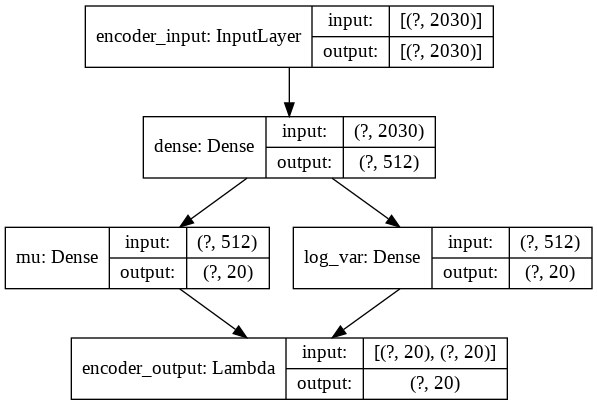

In [14]:
# ENCODER
def build_vae_encoder(input_dim, output_dim):
  
  # Clear tensorflow session to reset layer
  global K
  K.clear_session()
  
  # Define model input
  encoder_input = Input(shape = input_dim, name = 'encoder_input')
  
  #Intermediate layer
  x = Dense(intermediate_dim,activation='relu')(encoder_input)
 
  #Model Output
  mean_mu = Dense(output_dim, name = 'mu')(x)
  log_var = Dense(output_dim, name = 'log_var')(x)

  # Defining a function for sampling
  def sampling(args):
    mean_mu, log_var = args
    epsilon = K.random_normal(shape=K.shape(mean_mu), mean=0., stddev=1.) 
    return mean_mu + K.exp(log_var/2)*epsilon   
  
  # Using a Keras Lambda Layer to include the sampling function as a layer 
  # in the model
  encoder_output = Lambda(sampling, output_shape=(Z_DIM,), name='encoder_output')([mean_mu, log_var])

  return encoder_input, encoder_output, mean_mu, log_var, Model(encoder_input, encoder_output)

vae_encoder_input, vae_encoder_output,  mean_mu, log_var, vae_encoder  = build_vae_encoder(input_dim = INPUT_DIM,
                                                                                            output_dim = Z_DIM)
vae_encoder.summary()
# Plot the Encoder Model
plot_model(vae_encoder, to_file='smilesvae_encoder.png', show_shapes=True, show_layer_names=True, expand_nested=True)

In [15]:
print(type(vae_encoder_input))
print(type(vae_encoder_output))
print(type(vae_encoder))


<class 'tensorflow.python.framework.ops.Tensor'>
<class 'tensorflow.python.framework.ops.Tensor'>
<class 'tensorflow.python.keras.engine.functional.Functional'>



### **Building the Decoder**

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   [(None, 20)]              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               10752     
_________________________________________________________________
dense_2 (Dense)              (None, 2030)              1041390   
Total params: 1,052,142
Trainable params: 1,052,142
Non-trainable params: 0
_________________________________________________________________


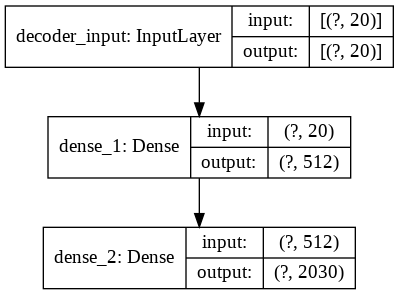

In [16]:

# Decoder
def build_decoder(input_dim, output_dim):

  # Define model input
  decoder_input = Input(shape = (input_dim,) , name = 'decoder_input')
  
  #Intermediate Layer
  x = Dense(intermediate_dim, activation='relu')(decoder_input)

    # Define model output
  decoder_output = Dense(output_dim, activation='sigmoid')(x)


  return decoder_input, decoder_output, Model(decoder_input, decoder_output)


vae_decoder_input, vae_decoder_output, vae_decoder = build_decoder(input_dim = Z_DIM, output_dim=orig_dim)
vae_decoder.summary()
# Plot the Encoder Model
plot_model(vae_decoder, to_file='smilesvae_decoder.png', show_shapes=True, show_layer_names=True, expand_nested=True)

### **Attaching Decoder to the Encoder**

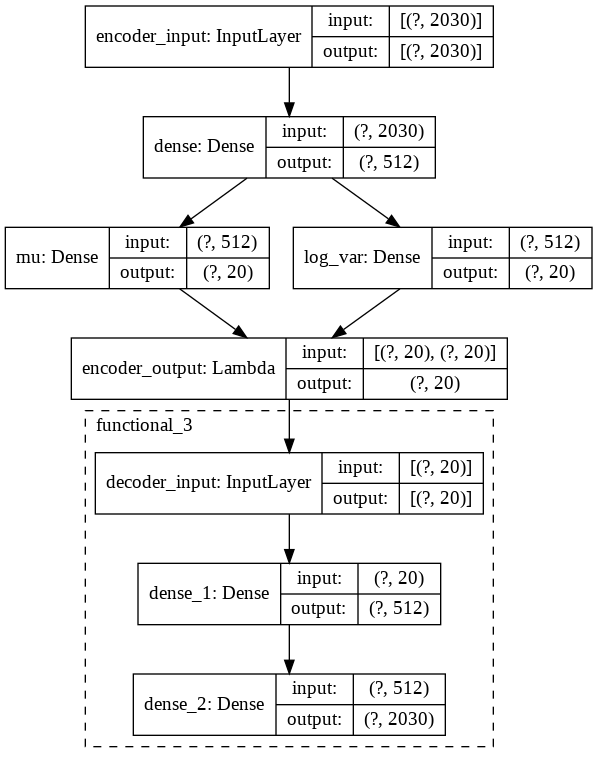

In [17]:
# The input to the model will be the smile string fed to the encoder.
vae_input = vae_encoder_input

# Output will be the output of the decoder. The term - decoder(encoder_output) 
# combines the model by passing the encoder output to the input of the decoder.
vae_output = vae_decoder(vae_encoder_output)

# Input to the combined model will be the input to the encoder.
# Output of the combined model will be the output of the decoder.
vae_model = Model(vae_input, vae_output)
# Plot the Encoder Model
plot_model(vae_model, to_file='smilesvae_model.png', show_shapes=True, show_layer_names=True, expand_nested=True)

### **Compiling and Training**

In [18]:
if __name__ == '__main__':
    models=(vae_encoder, vae_decoder)
    data=(X_test,X_test)

    reconstruction_loss = binary_crossentropy(vae_input, vae_output)
    reconstruction_loss = reconstruction_loss * orig_dim
    
    kl_loss = 1 + log_var - K.square(mean_mu) - K.exp(log_var)
    kl_loss = K.sum(kl_loss, axis=-1)    
    kl_loss = kl_loss * -0.5
    
    vae_loss = K.mean(reconstruction_loss + kl_loss)
    vae_model.add_loss(vae_loss)
    vae_model.compile(optimizer='adam')
    
    
    
#     Train the Variational AutoEncoder
    vae_model.fit(X_train, epochs=epochs, batch_size=BATCH_SIZE, validation_data=(X_test, None))
    vae_model.save_weights('vae_smiles.h5')
    
    

Epoch 1/50
569/569 [==============================] - 2s 3ms/step - loss: 128.8884 - val_loss: 88.1248
Epoch 2/50
569/569 [==============================] - 2s 3ms/step - loss: 80.5749 - val_loss: 74.7663
Epoch 3/50
569/569 [==============================] - 1s 3ms/step - loss: 70.4645 - val_loss: 68.7780
Epoch 4/50
569/569 [==============================] - 1s 3ms/step - loss: 64.6935 - val_loss: 64.8392
Epoch 5/50
569/569 [==============================] - 1s 3ms/step - loss: 61.2018 - val_loss: 62.7986
Epoch 6/50
569/569 [==============================] - 1s 3ms/step - loss: 58.6287 - val_loss: 61.3196
Epoch 7/50
569/569 [==============================] - 1s 3ms/step - loss: 56.5612 - val_loss: 59.4786
Epoch 8/50
569/569 [==============================] - 2s 3ms/step - loss: 54.6400 - val_loss: 58.8029
Epoch 9/50
569/569 [==============================] - 1s 3ms/step - loss: 53.1679 - val_loss: 57.6136
Epoch 10/50
569/569 [==============================] - 1s 3ms/step - loss: 51.669

In [19]:
reconst_Xtest = vae_model.predict(X_test, batch_size=BATCH_SIZE)
print(type(reconst_Xtest))

<class 'numpy.ndarray'>


### **Reconstructing Test Data Molecules**

In [20]:
reconst_Xtest = vae_model.predict(X_test, batch_size=BATCH_SIZE)
print(type(reconst_Xtest))
print(reconst_Xtest.shape)
print(X_test.shape)
reconst_test = reconst_Xtest.reshape(len(X_test), mol_size_x,mol_size_y)
test=X_test.reshape(len(X_test), mol_size_x, mol_size_y)
print(reconst_test.shape)
print(test.shape)

<class 'numpy.ndarray'>
(948, 2030)
(948, 2030)
(948, 58, 35)
(948, 58, 35)


!OC[C@H]1O[C@H](O)[C@H](O)[C@H](O)[C@@H]1OEEEEEEEEEEEEEEEE
58
OC[C@H]1O[C@H](O)[C@H](O)[C@H](O)[C@@H]1O
41


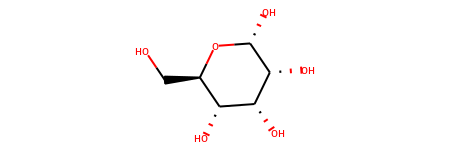

In [21]:
# Going back from vectorized form back to a readable string
idx=15
temp_str="".join([int_to_char[idx] for idx in np.argmax(test[idx,:,:], axis=1)])
print(temp_str)
print(len(temp_str))
temp_str = re.sub('!|E',"", temp_str)
print(temp_str)
print(len(temp_str))

m = Chem.MolFromSmiles(temp_str)
m

!OC[C@H]1O[C@H](O)[C@H](O)[C@H](O)[C@@H]1EEEEEEEEEEEEEEEEE
58
OC[C@H]1O[C@H](O)[C@H](O)[C@H](O)[C@@H]1
40


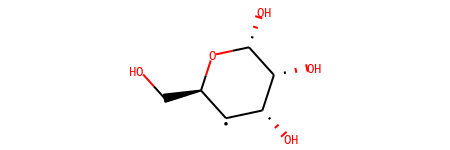

In [22]:
# Going back from vectorized form back to a readable string
temp_str="".join([int_to_char[idx] for idx in np.argmax(reconst_test[idx,:,:], axis=1)])
print(temp_str)
print(len(temp_str))
temp_str = re.sub('!|E',"", temp_str)
print(temp_str)
print(len(temp_str))

m = Chem.MolFromSmiles(temp_str)
m

# **Generating new Molecules from random latent vector sampled from standard normal distribution**

In [27]:
# Generating new Smile Strings sampled from a standard normal distribution
reconst_strings = vae_decoder.predict(np.random.normal(0,1,size=(10,Z_DIM)))
# print(type(reconst_strings))
# print(reconst_strings.shape)
reshaped_string=reconst_strings.reshape(10, mol_size_x, mol_size_y)
# print(reshaped_string.shape)

# Going back from vectorized form back to a readable string

temp_str="".join([int_to_char[idx] for idx in np.argmax(reshaped_string[0,:,:], axis=1)])
print(temp_str)
print(len(temp_str))
temp_str = re.sub('!|E',"", temp_str)
print(temp_str)
print(len(temp_str))

m = Chem.MolFromSmiles(temp_str)
m
m = Chem.MolFromSmiles(smi,sanitize=False)
if m is None:
  print('invalid SMILES')
else:
  try:
    Chem.SanitizeMol(m)
  except:
    print('invalid chemistry')

!CN(C@H]S(C(=)=O)C=OO)EEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE
58
CN(C@H]S(C(=)=O)C=OO)
21


RDKit ERROR: [07:26:59] SMILES Parse Error: syntax error while parsing: CN(C@H]S(C(=)=O)C=OO)
RDKit ERROR: [07:26:59] SMILES Parse Error: Failed parsing SMILES 'CN(C@H]S(C(=)=O)C=OO)' for input: 'CN(C@H]S(C(=)=O)C=OO)'


# **Visualizing Latent Space**

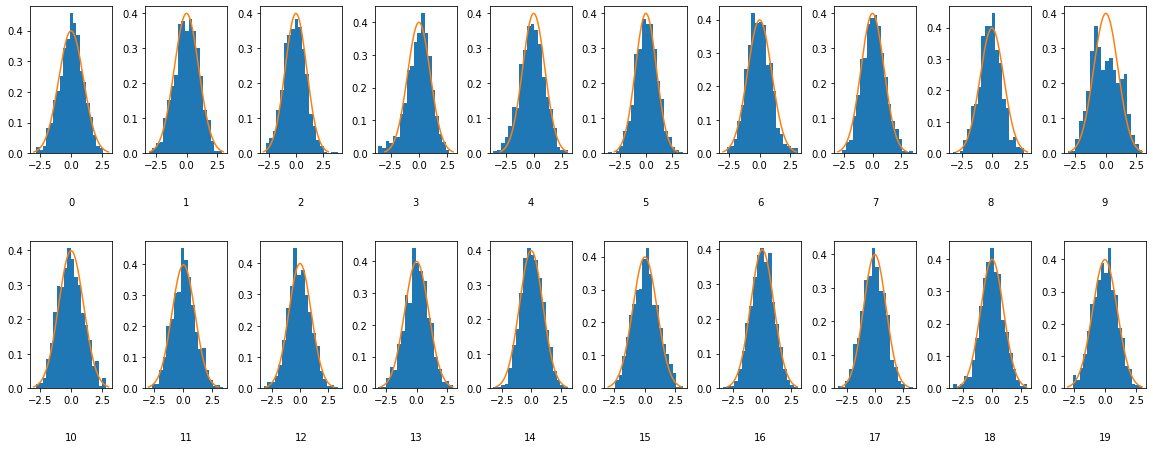

In [24]:
from scipy.stats import norm

z_test = vae_encoder.predict(X_test)

x = np.linspace(-3, 3, 300)

fig = plt.figure(figsize=(20, 20))
fig.subplots_adjust(hspace=0.6, wspace=0.4)

for i in range(20):
    ax = fig.add_subplot(5, 10, i+1)
    ax.hist(z_test[:,i], density=True, bins = 20)
    ax.axis('on')
    ax.text(0.5, -0.35, str(i), fontsize=10, ha='center', transform=ax.transAxes)
    ax.plot(x,norm.pdf(x))

plt.show()

[[-1.2718631   2.272187   -0.706343   ... -0.91911423 -0.77411675
   0.86471117]
 [-0.53419065 -0.2156051  -1.5876743  ...  0.40503296  0.18513417
  -1.2182038 ]
 [-0.00961024 -1.8303593  -0.84326863 ...  0.08297409 -0.4254319
  -1.7774081 ]
 ...
 [ 1.6899164   0.4868828   2.2638342  ... -0.22185612  1.4506726
  -0.20377019]
 [-0.4371035  -0.16705242 -0.51895577 ...  0.45264748 -0.08606002
  -1.1775583 ]
 [ 1.2655423  -1.0578771  -0.22845602 ... -0.35760415 -1.6777179
  -0.48118278]]


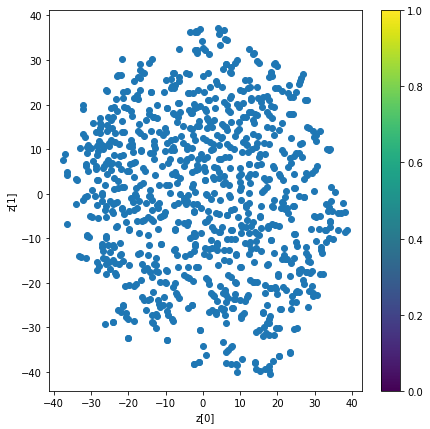

In [25]:
from sklearn.manifold import TSNE
z_mean = vae_encoder.predict(X_test)
print(z_mean)
model_name='VAESMILES_Latent'
os.makedirs(model_name, exist_ok=True)
filename = os.path.join(model_name, "smilesvae_mean.png")

z_embedded = TSNE(n_components=2).fit_transform(z_mean)
plt.figure(figsize=(7,7))
plt.scatter(z_embedded[:, 0], z_embedded[:, 1])
plt.colorbar()
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.savefig(filename)
plt.show()

In [26]:
print(z_mean.shape)
print(z_embedded.shape)

(948, 20)
(948, 2)
